In [1]:
import pandas as pd
import numpy as np 
import os 
import joblib 
from matplotlib.pyplot import plot as plt 


In [2]:
df_word_counts = pd.read_csv('/home/alo-tedy/Documents/myProject/Hadist/data_label/corpus/Words.csv')

In [3]:
df_word_counts

,Words,Counts
0,menceritakan,14601
1,alaihi,9928
2,wasallam,9885
3,shallallahu,9864
4,beliau,9243
...,...,...
17279,alqayyaam,1
17280,pembenarannya,1
17281,dikhususkan,1
17282,sukup,1


In [4]:
df_word_counts.shape

(17284, 2)

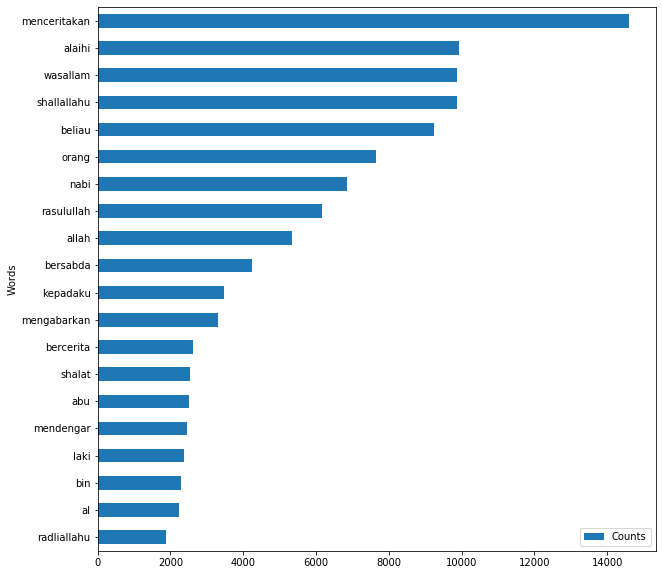

In [5]:
df_word_counts[:20].plot(kind='barh',figsize=(10,10),x='Words',y='Counts').invert_yaxis()

In [6]:
df_hadist_bukhari =pd.read_csv('/home/alo-tedy/Documents/myProject/Hadist/had_abudaud.csv',names=['L1','L2','Text'])

In [7]:
df_hadist_bukhari.Text

0       Telah menceritakan kepada kami [Abdullah bin M...
1       Telah menceritakan kepada kami [Musa bin Isma'...
2       Telah menceritakan kepada kami [Musaddad bin M...
3       Telah menceritakan kepada kami [Amru bin Marzu...
4       Telah menceritakan kepada kami [Abdullah bin M...
                              ...                        
4585    Telah menceritakan kepada kami [Musa bin Isma'...
4586    Telah menceritakan kepada kami [Musaddad] berk...
4587    Telah menceritakan kepada kami [Abdullah bin S...
4588    Telah menceritakan kepada kami [Muhammad bin I...
4589    Telah menceritakan kepada kami [Musa bin Isma'...
Name: Text, Length: 4590, dtype: object

## Model v1

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import re
import tqdm

In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [10]:
global stopwords

def load_stopwords(file):
    return [line.rstrip('\n\r') for line in open(file)]

stopwords = load_stopwords('/home/alo-tedy/Documents/myProject/Hadist/data_label/stopwords/stopword_list_TALA.txt')

### preprocess data

In [11]:
def text_lower(text):
  return text.lower()

def remove_entities(text):
  return re.sub(r'\[[^]]*\]', '', text)

def case_folding(text):
  return re.sub(r'[^a-z]', ' ', re.sub("'", '', text))

def stemming(text):
  return stemmer.stem(text)

def stopwords_removal(texts):
  texts_token = texts.split()
  not_stopword = []
  for token in texts_token:
    if token not in stopwords:
      not_stopword.append(token)
  return ' '.join(not_stopword)

In [12]:
def preprocessing(text):
  tx_lower = text_lower(text)
  tx_remove_entities = remove_entities(tx_lower)
  tx_case_folding = case_folding(tx_remove_entities)
  tx_stemming = stemming(tx_case_folding)
  tx_stopword = stopwords_removal(tx_stemming)
  return tx_stopword

In [13]:
hadist_preprocessing = df_hadist_bukhari.Text.apply(preprocessing)

In [14]:
hadist_preprocessing[:2]

0    cerita cerita nabi shallallahu alaihi wasallam...
1    cerita cerita abar cerita tatkala abdullah bin...
Name: Text, dtype: object

In [15]:
vectorizer = TfidfVectorizer()

In [16]:
X = vectorizer.fit_transform(hadist_preprocessing)

In [17]:
vectorizer.get_feature_names()[:10]

['aabatil',
 'aabiduuna',
 'aadait',
 'aafinii',
 'aafiyata',
 'aafiyatika',
 'aaidzan',
 'aajili',
 'aajilihi',
 'aajirnii']

In [18]:
X.shape

(4590, 7469)

In [19]:
type(X)

scipy.sparse.csr.csr_matrix

In [20]:
X.toarray()[:,0].shape

(4590,)

In [21]:
vectorizer.get_feature_names().index('nikah')

4806

## Model Test

In [22]:
sentence = 'bagaimana cara memilih pasangan yang sesuai sunnah untuk nikah ?'

In [23]:
sent_prep = preprocessing(sentence)

In [24]:
sent_prep

'pilih pasang sesuai sunnah nikah'

In [25]:
query = sent_prep.split()
res = np.zeros(X.shape[0])
not_in_corpus = []

for keyword in query:
    try:
        res += X.toarray()[:,vectorizer.get_feature_names().index(keyword)]
    except:
        not_in_corpus,append(keyword)
        res = np.zeros(X.shape[0])


In [26]:
not_in_corpus



[]

In [27]:
res

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
sum(res)

61.45068477307626

In [29]:
top_idx = np.argsort(-res)[:10]

In [30]:
top_idx

array([1350, 1366, 3794, 4166, 1300, 4233,  674, 1386, 1288, 4234])

In [31]:
### get hadist
valid = False
if sum(res)>0:
    valid = True

if valid:
    for i in range(len(top_idx)):
        print(res[top_idx[i]], df_hadist_bukhari.iloc[top_idx[i]][2])
else:
    print('dindt match, someting wrong')

0.7847847779748028 Telah menceritakan kepada kami [Musaddad], telah menceritakan kepada kami [Abu 'Awanah] dari [Al A'masy] dari [Abu Adh Dhuha] dari [Masruq] dari [Aisyah], ia berkata; Rasulullah shallallahu 'alaihi wasallam memberiku pilihan, maka aku memilih beliau, dan hal tersebut tidak dianggap sebagai perceraian. 
0.7300693850958725 Telah menceritakan kepada kami [Utsman bin Abu Syaibah], telah menceritakan kepada kami [Jarir] dari [Hisyam bin Urwah], dari [ayahnya] dari [Aisyah] mengenai kisah Barirah, ia berkata; suaminya adalah seorang budak. Kemudian Rasulullah shallallahu 'alaihi wasallam memberikan pilihan kepadanya, lalu ia memilih dirinya, dan seandainya Mughits adalah orang yang merdeka, maka beliau tidak akan memberikan pilihan kepadanya. 
0.6816658447679748 Telah menceritakan kepada kami [Al Qa'nabi] dari [Malik], dan telah diriwayatkan dari jalur yang lain: Telah menceritakan kepada kami [Musaddad bin Musarhad], telah menceritakan kepada kami [Yahya] dari ['Ubaidulla